In [5]:
%matplotlib inline
from lifetimes.datasets import load_cdnow_summary
data = load_cdnow_summary(index_col=[0])

print(data.head())

    frequency  recency      T
ID                           
1           2    30.43  38.86
2           1     1.71  38.86
3           0     0.00  38.86
4           0     0.00  38.86
5           0     0.00  38.86


## The shape of your data

The shape of your data
For all models, the following nomenclature is used:

* frequency represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases. This is actually slightly wrong. It’s the count of time periods the customer had a purchase in. So if using days as units, then it’s the count of days the customer had a purchase on.

* T represents the age of the customer in whatever time units chosen (weekly, in the above dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.

* recency represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)
If your data is not in the format (very common), there are utility functions in lifetimes to transform your data to look like this

## Basic Frequency/Recency analysis using the BG/NBD model

In [6]:
from lifetimes import BetaGeoFitter

# similar API to scikit-learn and lifelines.
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 2357 subjects, a: 0.79, alpha: 4.41, b: 2.43, r: 0.24>


After fitting, we have lots of nice methods and properties attached to the fitter object.

For small samples sizes, the parameters can get implausibly large, so by adding an l2 penalty the likelihood, we can control how large these parameters can be. This is implemented as setting as positive penalizer_coef in the initialization of the model. In typical applications, penalizers on the order of 0.001 to 0.1 are effective.

## Visualizing our Frequency/Recency Matrix

Consider: a customer bought from you every day for three weeks straight, and we haven’t heard from them in months. What are the chances they are still “alive”? Pretty small. On the other hand, a customer who historically buys from you once a quarter, and bought last quarter, is likely still alive. We can visualize this relationship using the Frequency/Recency matrix, which computes the expected number of transactions a artificial customer is to make in the next time period, given his or her recency (age at last purchase) and frequency (the number of repeat transactions he or she has made).

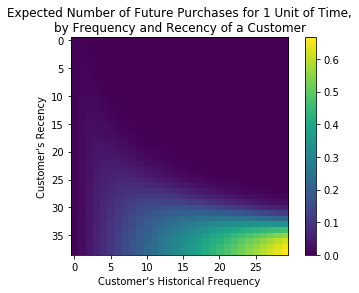

In [24]:
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf, T=1)

We can see that if a customer has bought 25 times from you, and their latest purchase was when they were 35 weeks old (given the individual is 35 weeks old), then they are your best customer (bottom-right). Your coldest customers are those that are in the top-right corner: they bought a lot quickly, and we haven’t seen them in weeks.

There’s also that beautiful “tail” around (5,25). That represents the customer who buys infrequently, but we’ve seen him or her recently, so they might buy again - we’re not sure if they are dead or just between purchases.

Another interesting matrix to look at is the probability of still being alive:

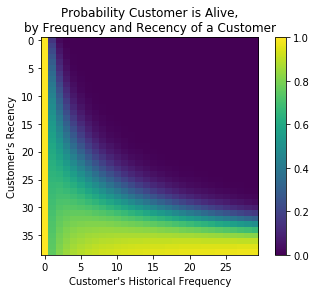

In [25]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

## Ranking customers from best to worst

Let’s return to our customers and rank them from “highest expected purchases in the next period” to lowest. Models expose a method that will predict a customer’s expected purchases in the next period using their history.

In [10]:
t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'],
                                                                                      data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,predicted_purchases
ID,,,,
509,18,35.14,35.86,0.424877
841,19,34.00,34.14,0.474738
1981,17,28.43,28.86,0.486526
157,29,37.71,38.00,0.662397
1516,26,30.86,31.00,0.710624


Great, we can see that the customer who has made 26 purchases, and bought very recently from us, is probably going to buy again in the next period.

## Assessing model fit
Ok, we can predict and we can visualize our customers’ behaviour, but is our model correct? There are a few ways to assess the model’s correctness. The first is to compare your data versus artificial data simulated with your fitted model’s parameters.

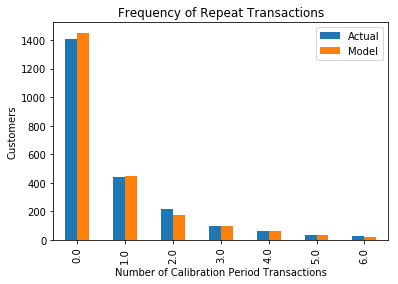

In [11]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

## Example using transactional datasets

Most often, the dataset you have at hand will be at the transaction level. Lifetimes has some utility functions to transform that transactional data (one row per purchase) into summary data (a frequency, recency and age dataset).



In [26]:
from lifetimes.datasets import load_transaction_data
from lifetimes.utils import summary_data_from_transaction_data

transaction_data = load_transaction_data()
print(transaction_data.head())

                  date  id
0  2014-03-08 00:00:00   0
1  2014-05-21 00:00:00   1
2  2014-03-14 00:00:00   2
3  2014-04-09 00:00:00   2
4  2014-05-21 00:00:00   2


In [27]:
summary = summary_data_from_transaction_data(transaction_data, 'id', 'date', observation_period_end='2014-12-31')

print(summary.head())

    frequency  recency      T
id                           
0         0.0      0.0  298.0
1         0.0      0.0  224.0
2         6.0    142.0  292.0
3         0.0      0.0  147.0
4         2.0      9.0  183.0


## More model fitting
With transactional data, we can partition the dataset into a calibration period dataset and a holdout dataset. This is important as we want to test how our model performs on data not yet seen (think cross-validation in standard machine learning literature). Lifetimes has a function to partition our dataset like this:

In [28]:
from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(transaction_data, 'id', 'date',
                                        calibration_period_end='2014-09-01',
                                        observation_period_end='2014-12-31' )   
print(summary_cal_holdout.head())

    frequency_cal  recency_cal  T_cal  frequency_holdout  duration_holdout
id                                                                        
0             0.0          0.0  177.0                0.0               121
1             0.0          0.0  103.0                0.0               121
2             6.0        142.0  171.0                0.0               121
3             0.0          0.0   26.0                0.0               121
4             2.0          9.0   62.0                0.0               121


With this dataset, we can perform fitting on the _cal columns, and test on the _holdout columns:

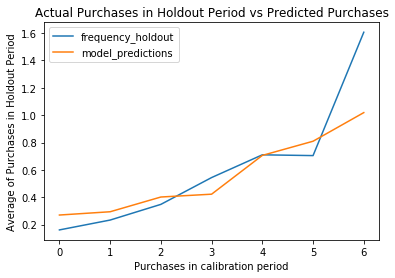

In [29]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

## Customer Predictions

Based on customer history, we can predict what an individuals future purchases might look like:



In [30]:
t = 10 #predict purchases in 10 periods
individual = summary.iloc[20]
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_to_time`
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.05765126901151552

In [31]:
individual

frequency      2.0
recency       96.0
T            159.0
Name: 20, dtype: float64

## Customer Probability Histories
Given a customer transaction history, we can calculate their historical probability of being alive, according to our trained model. For example:



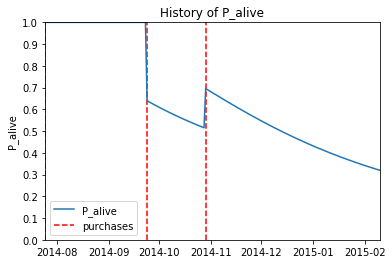

In [37]:
from lifetimes.plotting import plot_history_alive

id = 20
days_since_birth = 200
sp_trans = transaction_data.loc[transaction_data['id'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'date')

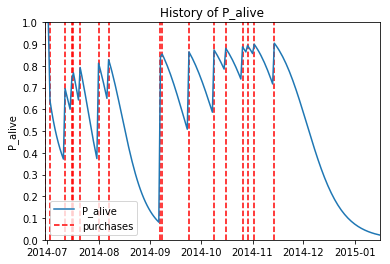

In [38]:
id = 35
days_since_birth = 200
sp_trans = transaction_data.loc[transaction_data['id'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'date')

## Estimating customer lifetime value using the Gamma-Gamma model

For this whole time we didn’t take into account the economic value of each transaction and we focused mainly on transactions’ occurrences. To estimate this we can use the Gamma-Gamma submodel. But first we need to create summary data from transactional data also containing economic values for each transaction (i.e. profits or revenues).

In [41]:
from lifetimes.datasets import load_cdnow_summary_data_with_monetary_value

summary_with_money_value = load_cdnow_summary_data_with_monetary_value()
summary_with_money_value.head()


,frequency,recency,T,monetary_value
customer_id,,,,
1,2,30.43,38.86,22.35
2,1,1.71,38.86,11.77
3,0,0.00,38.86,0.00
4,0,0.00,38.86,0.00
5,0,0.00,38.86,0.00


In [42]:
returning_customers_summary = summary_with_money_value[summary_with_money_value['frequency']>0]

print(returning_customers_summary.head())

             frequency  recency      T  monetary_value
customer_id                                           
1                    2    30.43  38.86           22.35
2                    1     1.71  38.86           11.77
6                    7    29.43  38.86           73.74
7                    1     5.00  38.86           11.77
9                    2    35.71  38.86           25.55


## The Gamma-Gamma model and the independence assumption

The model we are going to use to estimate the CLV for our userbase is called the Gamma-Gamma submodel, which relies upon an important assumption. The Gamma-Gamma submodel, in fact, assumes that there is no relationship between the monetary value and the purchase frequency. In practice we need to check whether the Pearson correlation between the two vectors is close to 0 in order to use this model.

In [43]:
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.113884
frequency,0.113884,1.000000


At this point we can train our Gamma-Gamma submodel and predict the conditional, expected average lifetime value of our customers.

In [44]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 946 subjects, p: 6.25, q: 3.74, v: 15.45>


In [45]:
print(ggf.conditional_expected_average_profit(
        summary_with_money_value['frequency'],
        summary_with_money_value['monetary_value']
    ).head(10))

customer_id
1     24.658614
2     18.911474
3     35.171005
4     35.171005
5     35.171005
6     71.462854
7     18.911474
8     35.171005
9     27.282406
10    35.171005
dtype: float64


In [47]:
print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        summary_with_money_value['frequency'],
        summary_with_money_value['monetary_value']
    ).mean(),
    summary_with_money_value[summary_with_money_value['frequency']>0]['monetary_value'].mean()
))

Expected conditional average profit: 35.25296023627735, Average profit: 35.07855179704026


While for computing the total CLV using the DCF method (https://en.wikipedia.org/wiki/Discounted_cash_flow) adjusting for cost of capital:

In [48]:
# refit the BG model to the summary_with_money_value dataset
bgf.fit(summary_with_money_value['frequency'], summary_with_money_value['recency'], summary_with_money_value['T'])

print(ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    summary_with_money_value['frequency'],
    summary_with_money_value['recency'],
    summary_with_money_value['T'],
    summary_with_money_value['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
).head(10))

customer_id
1      140.095130
2       18.943358
3       38.180529
4       38.180529
5       38.180529
6     1003.852771
7       28.109545
8       38.180529
9      167.416974
10      38.180529
Name: clv, dtype: float64
